# Clustering race strategies

In [23]:
import seaborn as sns
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import itertools
from itertools import groupby
import pickle
import os
import math
import numpy as np
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.style.use('fivethirtyeight')
sns.set_style("whitegrid", {'axes.grid' : False})
#sns.mpl.rcParams['figure.figsize'] = (16, 10)

# Directory to store pickled dataframes
directory = './formula-1-race-data/dataframes/'

pd.options.mode.chained_assignment = None 

In [2]:
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import pdist
from mpl_toolkits.mplot3d import Axes3D
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler 

In [3]:
def read_from_pickle(directory, filename):
    df = pd.DataFrame()
    filepath = directory + filename
    with open(filepath, 'rb') as file:
        df = pickle.load(file)
            
    return df

In [4]:
dr_stint = read_from_pickle(directory, "dr_stint.pickle")
dr_stint['year'] = dr_stint['year'].astype(int)
pirelli = read_from_pickle(directory, "pirelli.pickle")
dataset = pd.read_csv(directory + 'dataset.csv')

In [5]:
index_list = ['year', 'driverRef', 'name']
pirelli = pirelli[pirelli['name'] != 'German Grand Prix']

In [6]:
cat1 = ['1SS', '1S', '1M', '2SS', '2S', '2M', '3SS', '3S', '3M', '4SS', '4S', '4M'] # SS, S, M = 1, # S, M = 1
cat2 = ['1H', '1S', '1M', '2H', '2S', '2M', '3H', '3S', '3M', '4H', '4S', '4M'] # S, M, H = 2, # M, H = 2
cat3 = ['1SS', '1S', '1US', '2SS', '2S', '2US', '3SS', '3S', '3US', '4SS', '4S', '4US']  # SS, S, US = 3, # SS, S = 3

In [12]:
def get_clusters(df_one_race, index_list, max_dist):
    
    # Data prep (DF CONTAINS ONE ONE RACE ONLY)
    df = df_one_race.drop(index_list, axis=1)
    X = df.as_matrix(columns=None)
    Z = linkage(X, 'ward')
    c, coph_dists = cophenet(Z, pdist(X))
    clusters = fcluster(Z, max_dist, criterion='distance')

    report = pd.DataFrame({"Number of clusters": len(set(clusters)), "c": c}, index=[0])
    cl = pd.DataFrame(clusters, columns=['clusters'])
    cl['max dist'] = max_dist
    df_cl = pd.concat([df_one_race.reset_index(drop=True), cl], axis=1)
    
    return report, df_cl


In [8]:
def plot_dendogram(df_one_race):
    
    # Data prep (DF CONTAINS ONE ONE RACE ONLY)
    df = df_one_race.drop(index_list, axis=1)
    X = df.as_matrix(columns=None)
    Z = linkage(X, 'ward')
    
    # plotting
    plt.title('Dendrogram')
    plt.xlabel('Index Numbers')
    plt.ylabel('Distance')
    dendrogram(
        Z,
        leaf_rotation=90.,  
        leaf_font_size=8.,
    )
    plt.show()

In [9]:
def plot_clusters(df, row, col, scatter_x, scatter_y, hue, col_for_s):
    
    g = sns.FacetGrid(df, row=row, col=col, hue=hue, aspect=1, size=4, palette='Set2')
    g.map(plt.scatter, scatter_x, scatter_y, alpha=0.8, edgecolor='white', linewidth=0.5, s=100+df[col_for_s]*20)
    fig = g.fig 
    fig.subplots_adjust(top=0.8, wspace=0.3)
    l = g.add_legend(title=hue)


## Clustering each race individually

In [15]:
def get_clusters_per_race_loop(df, index_list, pirelli, category, max_dist, cols):
    
    df_report_all = pd.DataFrame()
    df_clusters_all = pd.DataFrame()
    
    p = pirelli[pirelli['mandatory combi'] == category].sort_values(['name', 'year'])
    p_races = p[['year', 'name']].to_dict('list')
    
    for k,v in zip(p_races['year'], p_races['name']):
        for i in max_dist:
            df_report, df_clusters = get_clusters(df[(df['year'] == k) & (df['name'] == v)][index_list+ cols],
                                                  index_list, max_dist=i)
            df_report['year'] = k
            df_report['name'] = v
            df_report['max dist'] = i
            df_report_all = pd.concat([df_report_all, df_report])
            
            df_clusters['pirelli category'] = category
            df_clusters_all = pd.concat([df_clusters_all, df_clusters])
            
    return df_report_all, df_clusters_all

In [16]:
max_dist = [25,50,75,100]
df_report_cat1, df_clusters_cat1 = get_clusters_per_race_loop(dr_stint, index_list, pirelli,1, max_dist, cat1)
df_report_cat2, df_clusters_cat2 = get_clusters_per_race_loop(dr_stint, index_list, pirelli,2, max_dist, cat2)
df_report_cat3, df_clusters_cat3 = get_clusters_per_race_loop(dr_stint, index_list, pirelli,3, max_dist, cat3)

/Users/dianaow/anaconda2/lib/python2.7/site-packages/scipy/cluster/hierarchy.py:1280: RuntimeWarning: invalid value encountered in double_scalars
  c = numerator.sum() / np.sqrt((denomA.sum() * denomB.sum()))


### Visualize how a race is clustered

#### eg. 2016 Australian Grand Prix -> Pirelli Cat 1 race

In [17]:
SS = cat1[0::3]
S = cat1[1::3]
M = cat1[2::3]

In [18]:
aus = dr_stint[(dr_stint['year'] == 2016) & (dr_stint['name'] == \
                                             'Australian Grand Prix')][index_list+ cat1].reset_index(drop=True)
aus = pd.merge(aus, dataset[index_list+['statusId']], on=index_list, how='left')
aus[aus['statusId'] == 0]

,year,driverRef,name,1SS,1S,1M,2SS,2S,2M,3SS,3S,3M,4SS,4S,4M,statusId
0,2016,alonso,Australian Grand Prix,12.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2016,ericsson,Australian Grand Prix,11.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0
5,2016,gutierrez,Australian Grand Prix,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,2016,haryanto,Australian Grand Prix,12.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,2016,raikkonen,Australian Grand Prix,16.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
max_dist = [50,75,100]
df_aus = pd.DataFrame()
for i in max_dist:
    df_report, df_clusters = get_clusters(aus, index_list, max_dist=i)
    df_aus = pd.concat([df_aus, df_clusters])

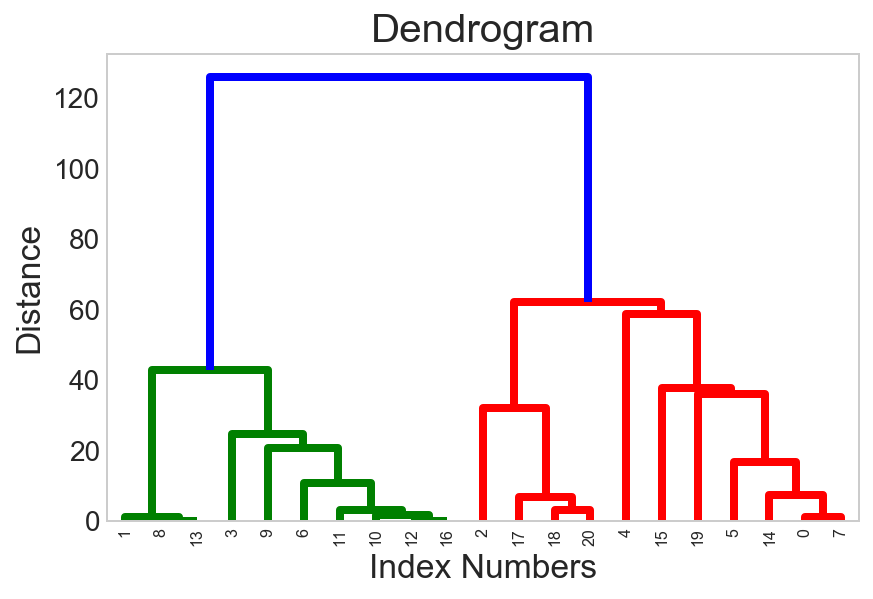

In [24]:
plot_dendogram(aus)

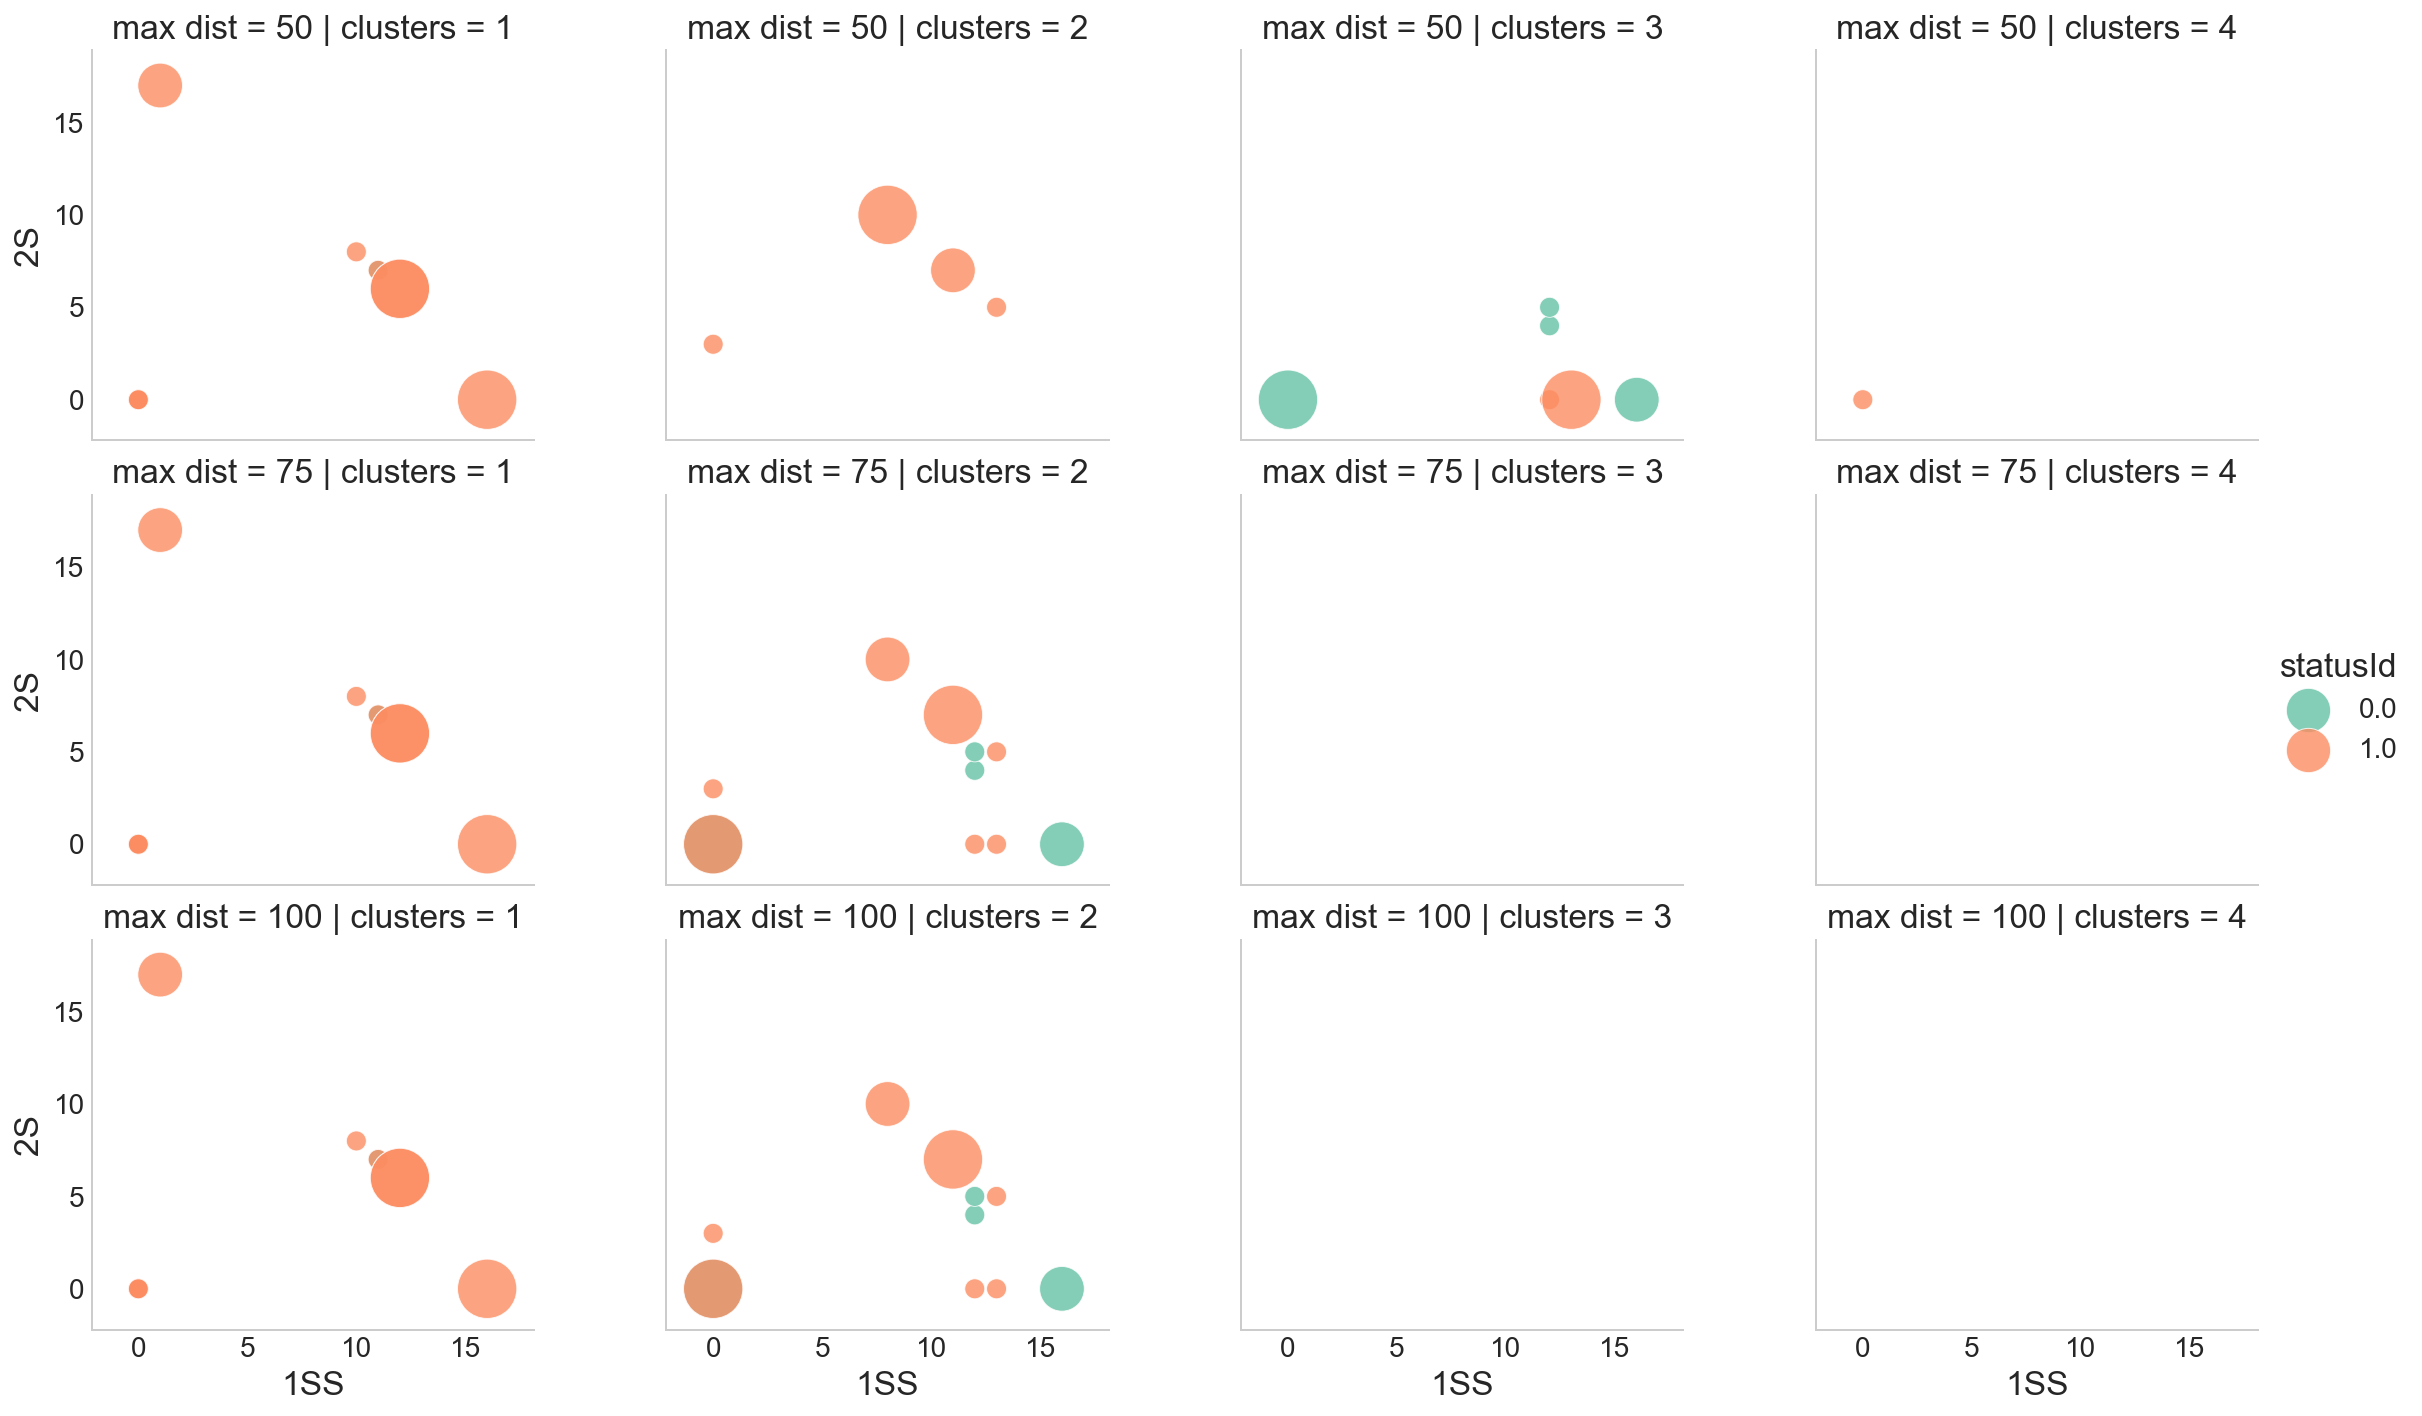

In [25]:
plot_clusters(df=df_aus, row='max dist', col='clusters', scatter_x=SS[0], scatter_y=S[1],
              hue='statusId', col_for_s=M[2])

#### eg. 2016 Azerbaijan Grand Prix

In [26]:
aze = dr_stint[(dr_stint['year'] == 2016) & (dr_stint['name'] == \
                                             'Azerbaijan Grand Prix')][index_list+ cat1].reset_index(drop=True)
aze = pd.merge(aze, dataset[index_list+['statusId']], on=index_list, how='left')
aze[aze['statusId'] == 0]

,year,driverRef,name,1SS,1S,1M,2SS,2S,2M,3SS,3S,3M,4SS,4S,4M,statusId
0,2016,alonso,Azerbaijan Grand Prix,5.0,0.0,0.0,0.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,2016,kvyat,Azerbaijan Grand Prix,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18,2016,sainz,Azerbaijan Grand Prix,4.0,0.0,0.0,0.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21,2016,wehrlein,Azerbaijan Grand Prix,0.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
max_dist = [50,75,100]
df_aze = pd.DataFrame()
for i in max_dist:
    df_report, df_clusters = get_clusters(aze, index_list, max_dist=i)
    df_aze = pd.concat([df_aze, df_clusters])

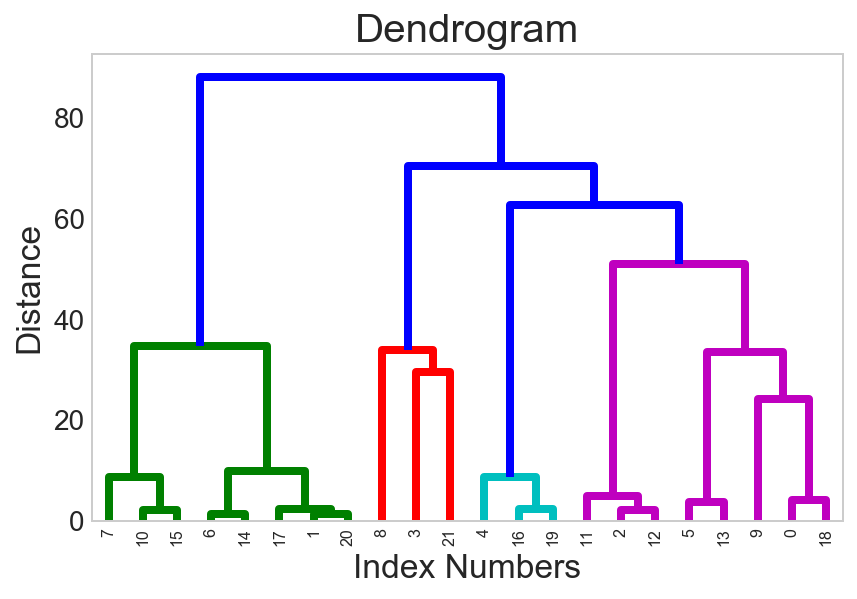

In [30]:
plot_dendogram(aze)

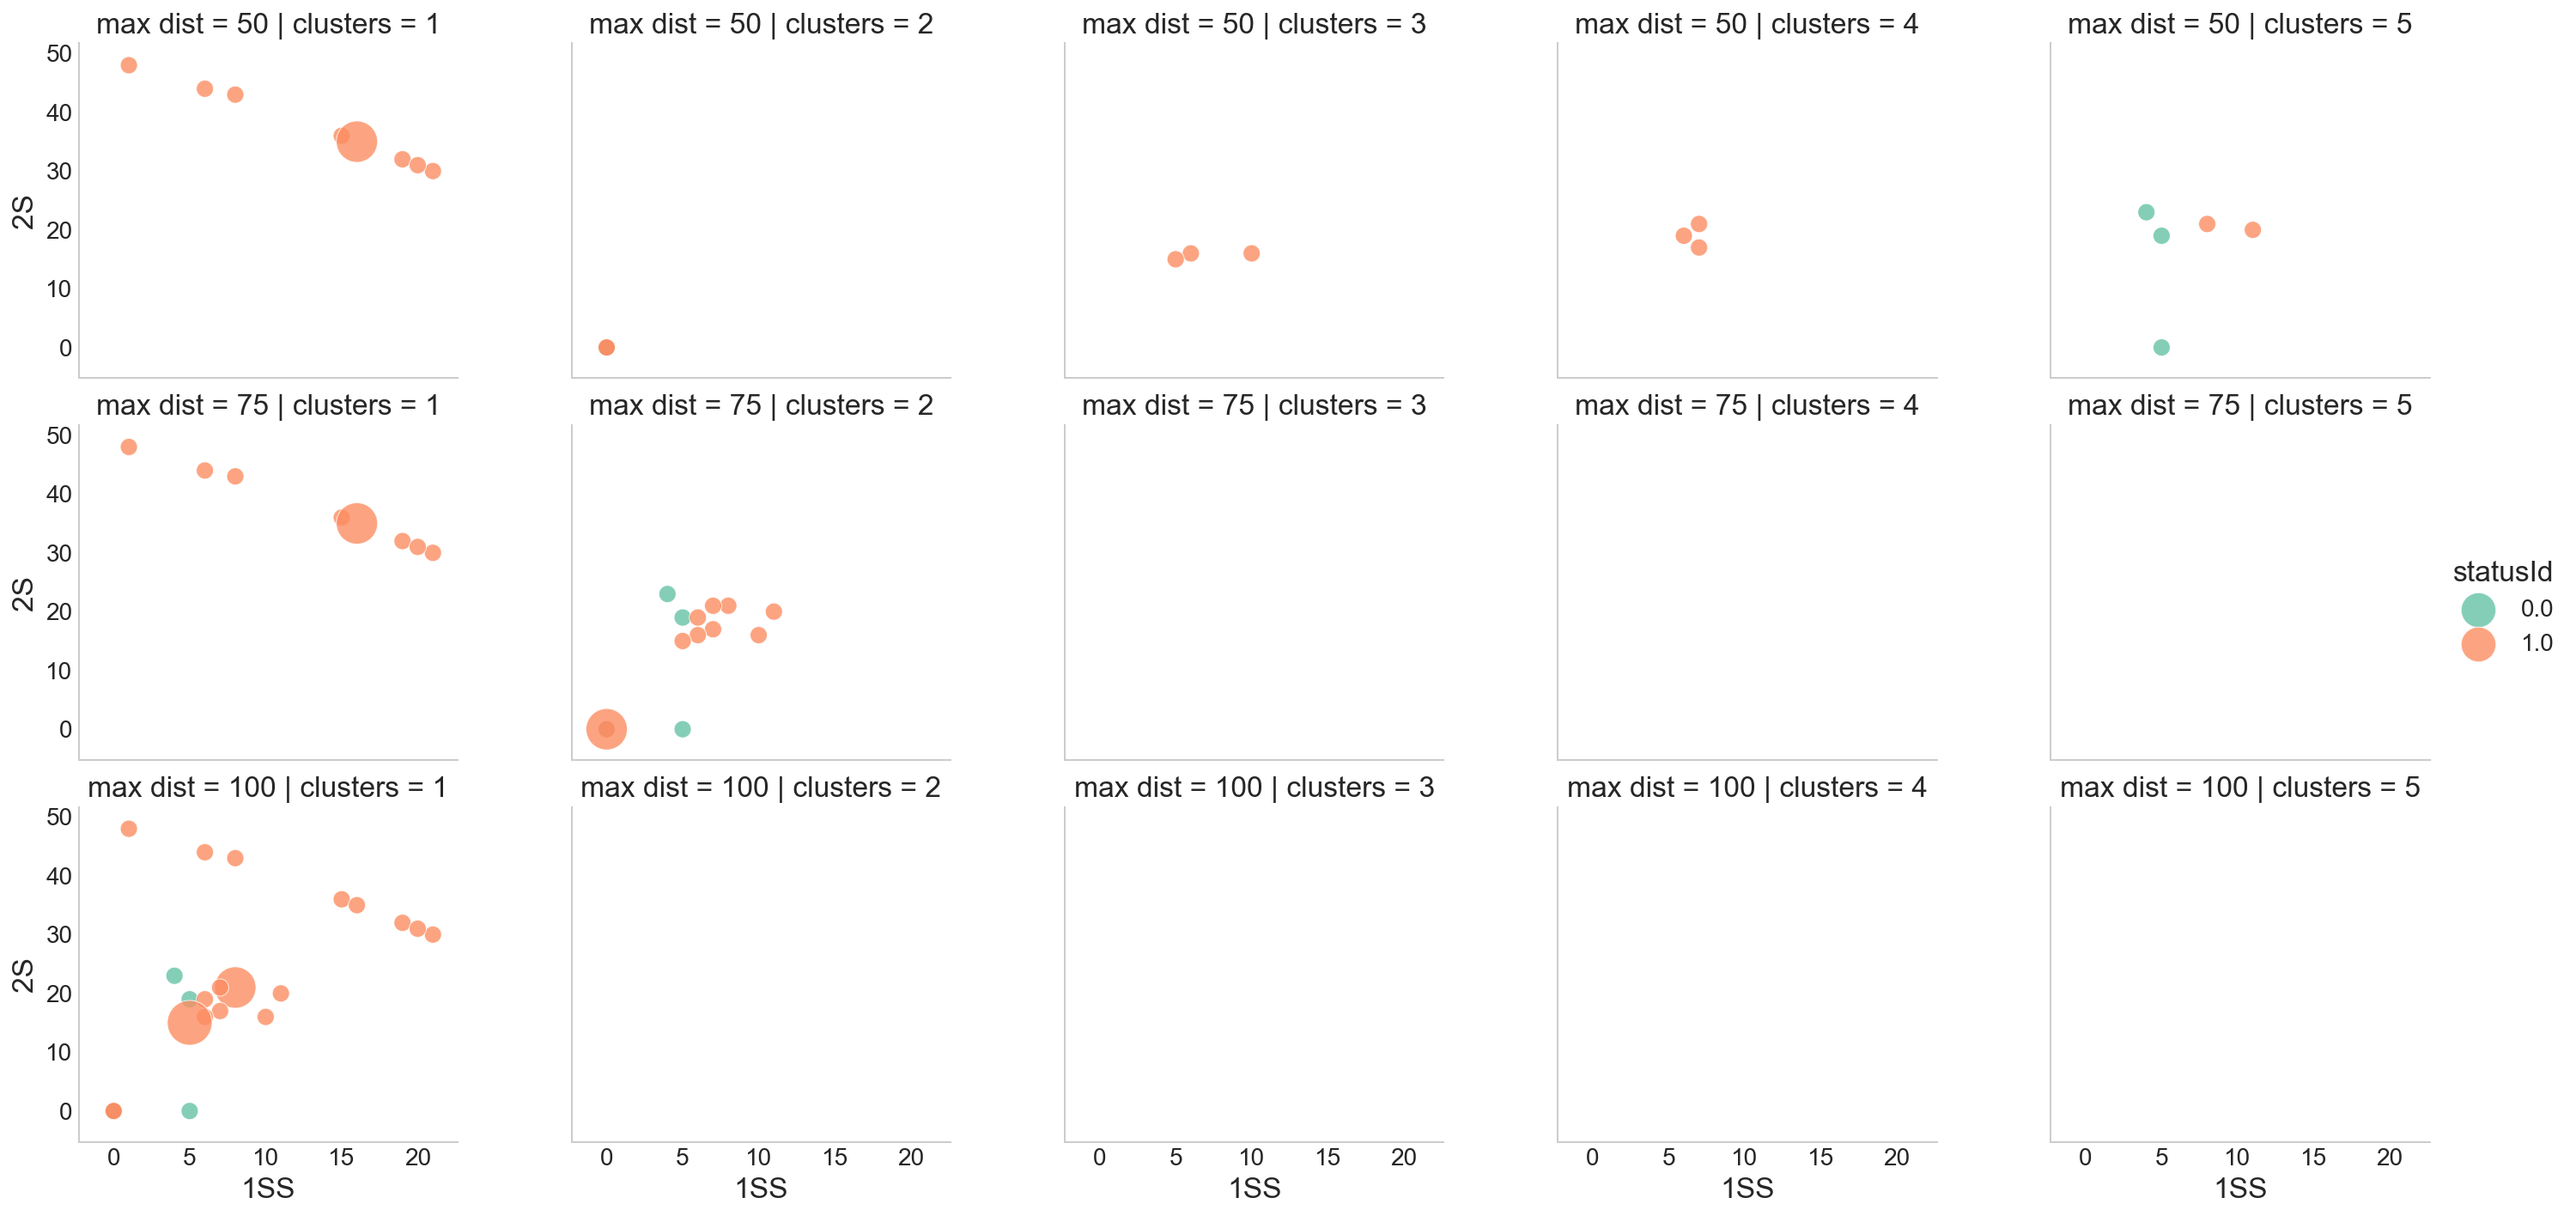

In [31]:
plot_clusters(df=df_aze, row='max dist', col='clusters', scatter_x=SS[0], scatter_y=S[1],
              hue='statusId', col_for_s=M[2])

#### eg. 2016 Azerbaijan Grand Prix

In [52]:
aze17 = dr_stint[(dr_stint['year'] == 2017) & (dr_stint['name'] == \
                                             'Azerbaijan Grand Prix')][index_list+ cat1].reset_index(drop=True)
aze17 = pd.merge(aze17, dataset[index_list+['statusId']], on=index_list, how='left')
aze17[aze17['statusId'] == 0]

,year,driverRef,name,1SS,1S,1M,2SS,2S,2M,3SS,3S,3M,4SS,4S,4M,statusId
5,2017,hulkenberg,Azerbaijan Grand Prix,13.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,2017,kvyat,Azerbaijan Grand Prix,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,2017,massa,Azerbaijan Grand Prix,12.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,2017,palmer,Azerbaijan Grand Prix,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,2017,perez,Azerbaijan Grand Prix,12.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,2017,raikkonen,Azerbaijan Grand Prix,12.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,2017,verstappen,Azerbaijan Grand Prix,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
max_dist = [50,75,100]
df_aze17 = pd.DataFrame()
for i in max_dist:
    df_report, df_clusters = get_clusters(aze17, index_list, max_dist=i)
    df_aze17 = pd.concat([df_aze17, df_clusters])

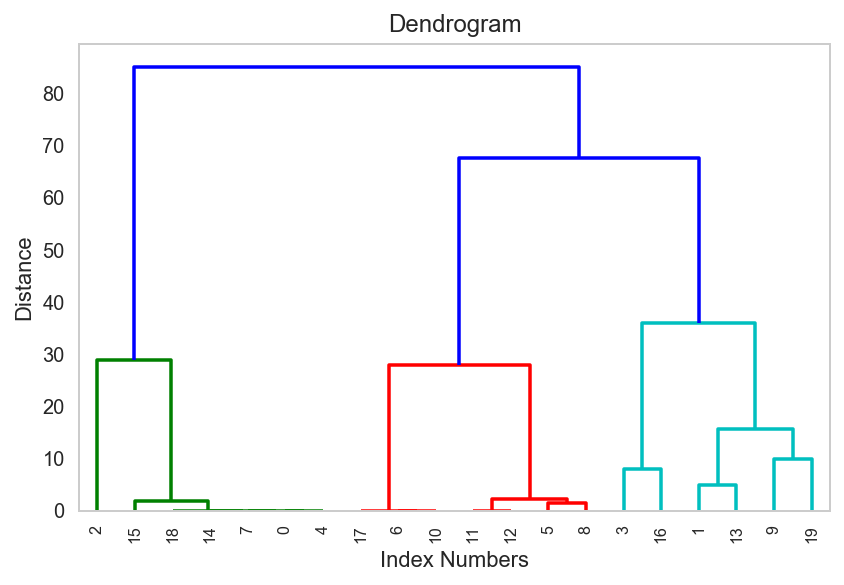

In [54]:
plot_dendogram(aze17)

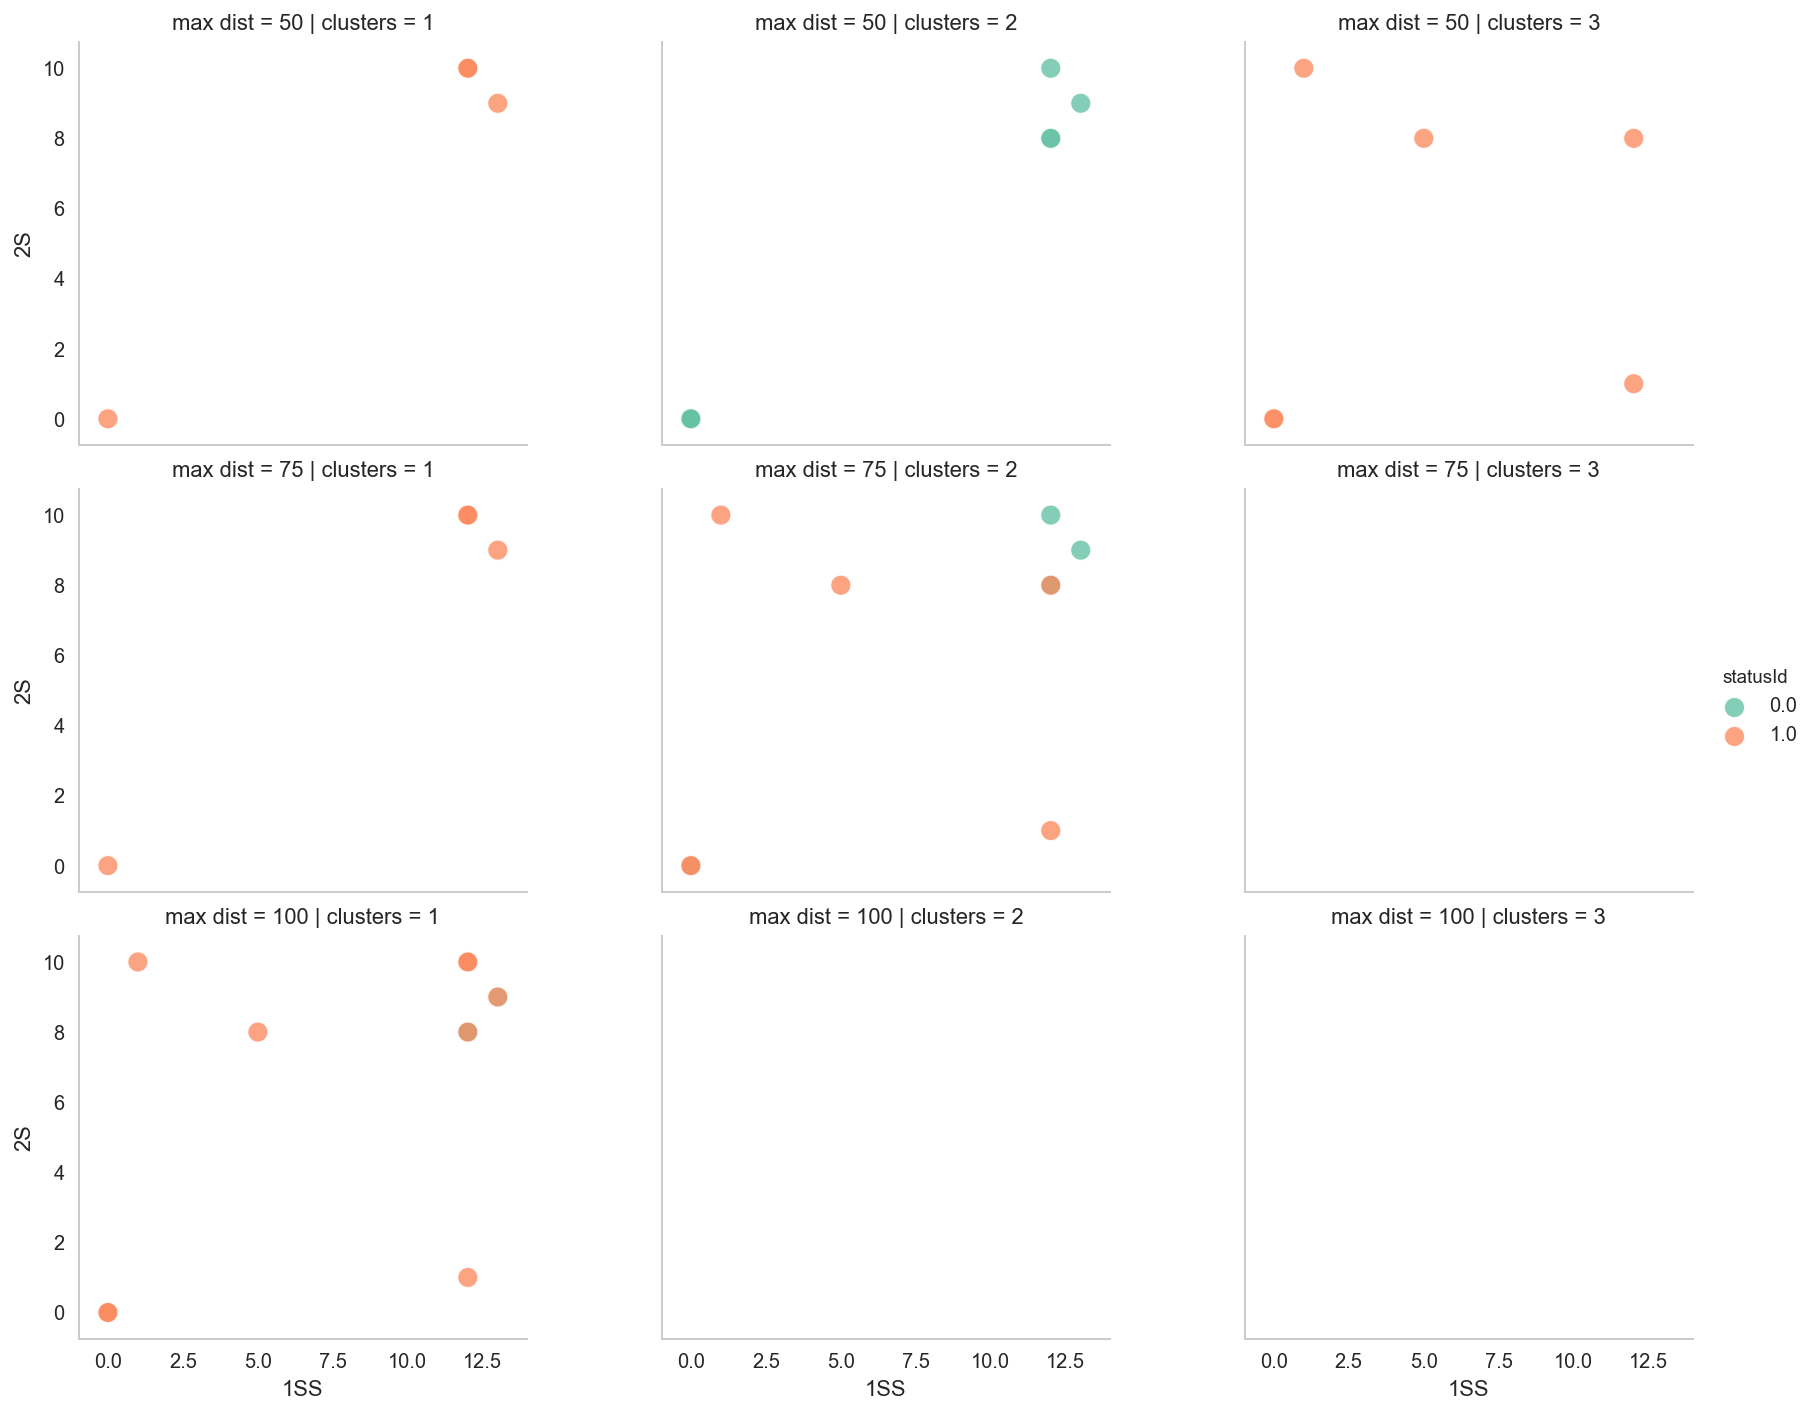

In [55]:
plot_clusters(df=df_aze17, row='max dist', col='clusters', scatter_x=SS[0], scatter_y=S[1],
              hue='statusId', col_for_s=M[2])

### Visualize relationship between distance threshold and number of clusters

<Figure size 720x1152 with 0 Axes>

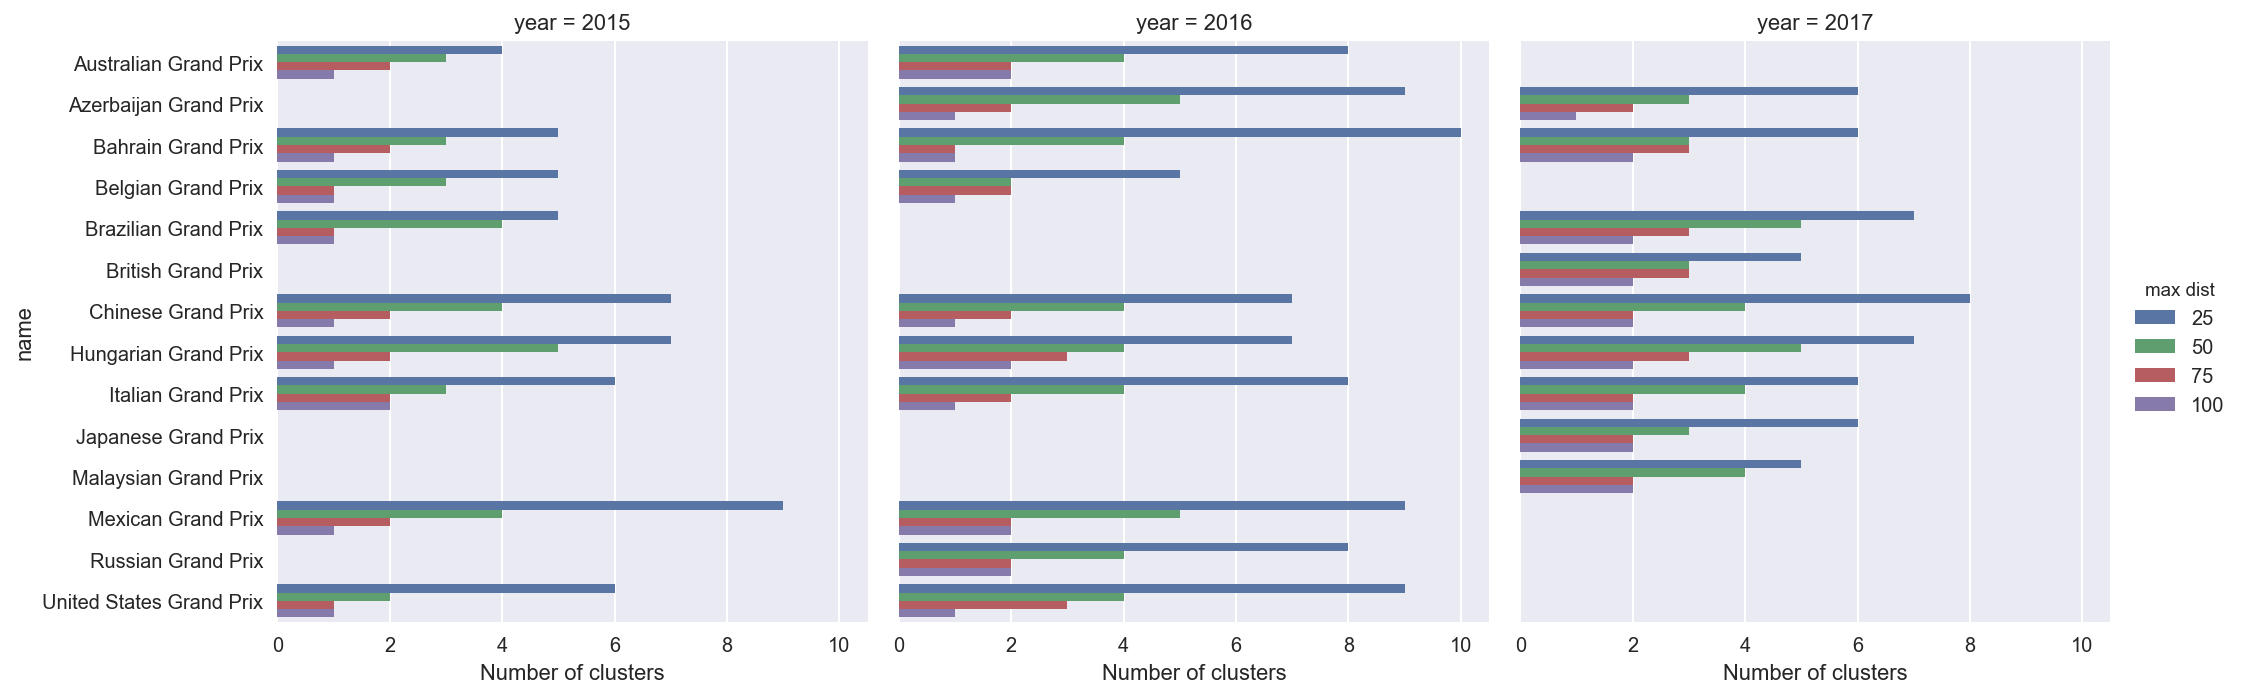

In [32]:
plt.figure(figsize=(10,16))
sns.set(font_scale=1)
g = sns.factorplot(x='Number of clusters', y='name', col='year', kind="bar", hue='max dist', orient='h',
                   data=df_report_cat1, size=5, aspect=1)

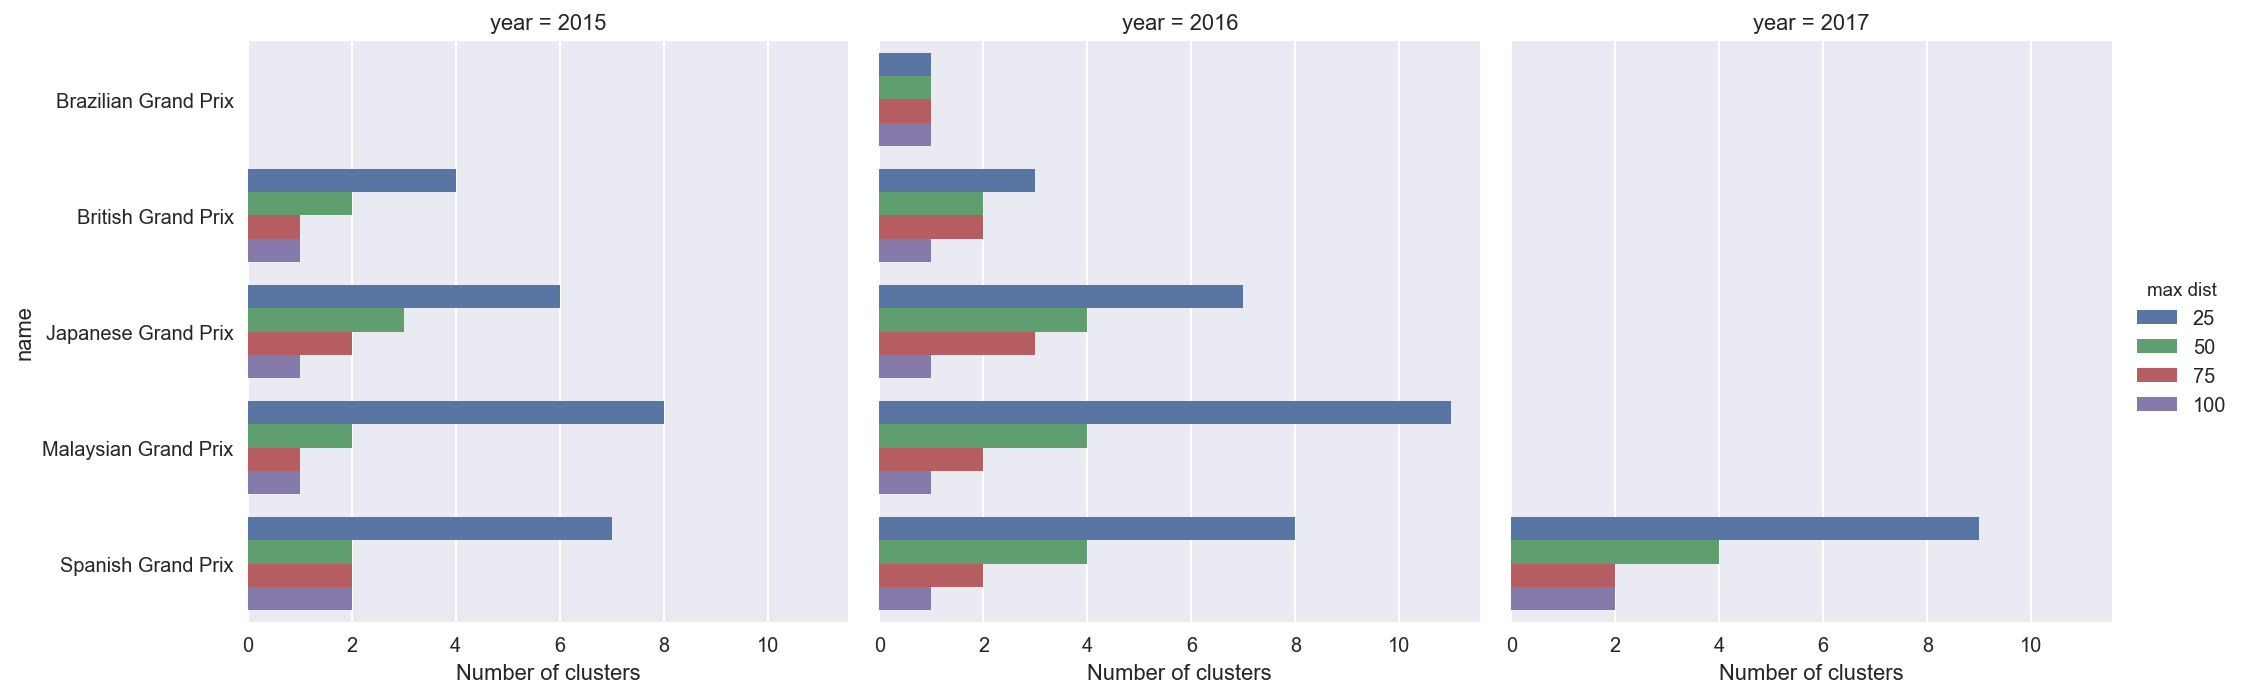

In [33]:
g = sns.factorplot(x='Number of clusters', y='name', col='year', kind="bar", hue='max dist', orient='h',
                   data=df_report_cat2, size=5, aspect=1)

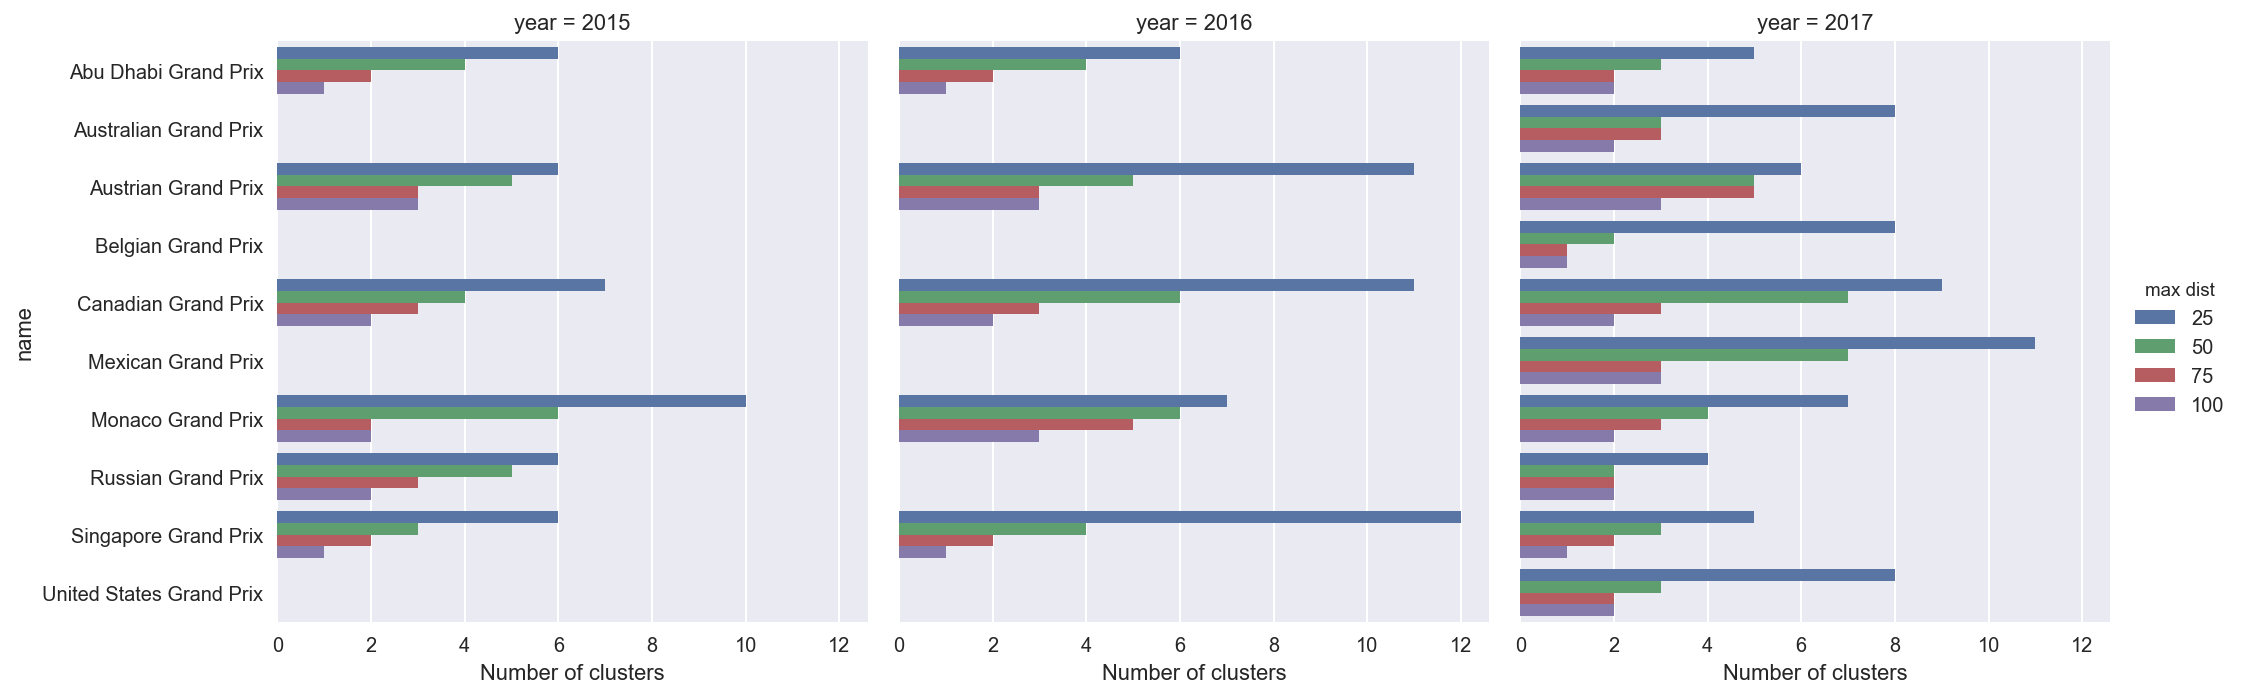

In [34]:
g = sns.factorplot(x='Number of clusters', y='name', col='year', kind="bar", hue='max dist', orient='h',
                   data=df_report_cat3, size=5, aspect=1)

### Visualize relationship between clusters and drivers

In [35]:
df_clusters = pd.concat([df_clusters_cat1, df_clusters_cat2, df_clusters_cat3])
le = preprocessing.LabelEncoder()
le.fit(df_clusters['driverRef'])

LabelEncoder()

In [36]:
def scatter_plot(df):
    
    nrows=1
    ncols=3
    fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", sharey="all", figsize=(20,5), squeeze=False)
    year = [2015, 2016, 2017]

    for row in range(nrows):
        for col in range(ncols): 
            g = sns.regplot(x='driverRef label', y='clusters', data=df[(df['year'] == year[col])],
                            ax=axes[row][col], fit_reg=False, scatter_kws={'alpha':0.25})
            g.title.set_text(year[col])
            fig.suptitle('Pirelli Category: ' + str(df['pirelli category'].unique()))

In [37]:
def swarm_plot(df):
    
    nrows=1
    ncols =3
    fig, axes = plt.subplots(nrows = 1, ncols = 3, sharex="all", sharey="all", figsize=(15,5), squeeze=False)
    year = [2015, 2016, 2017]

    for row in range(nrows):
        for col in range(ncols):
            g = sns.swarmplot(x='statusId', y='clusters', data=df[df['year'] == year[col]], ax=axes[row][col])
            g.title.set_text(year[col])
            fig.suptitle('Pirelli Category: ' + str(df['pirelli category'].unique()))

In [38]:
def strip_plot(df):
    
    sns.set_style("whitegrid", {'axes.grid' : False})

    nrows=1
    ncols =3
    fig, axes = plt.subplots(nrows = 1, ncols = 3, sharex="all", sharey="all", figsize=(15,10), squeeze=False)
    year = [2015, 2016, 2017]

    for row in range(nrows):
        for col in range(ncols):  
            g = sns.stripplot(x='clusters', y='driverRef label', data=df[(df['year'] == year[col])],
                              ax=axes[row][col], jitter=0.5, palette="Paired", size=5, orient='h')


In [39]:
def data_prep(df, dataset, index_list, le, max_dist):

    df = df[df['max dist'] == max_dist].reset_index(drop=True)
    df['driverRef label'] = le.transform(df['driverRef']) 
    df = pd.merge(df, dataset[index_list+['statusId']], on=index_list, how='left')

    return df

def plot_loop(dfs, status_dataset_1a, index_list, le, max_dist):
    df_all = pd.DataFrame()
    for i in dfs:
        df = data_prep(i, status_dataset_1a, index_list, le, max_dist)
        df_all = pd.concat([df_all, df])
        swarm_plot(df)
        strip_plot(df)
    return df_all

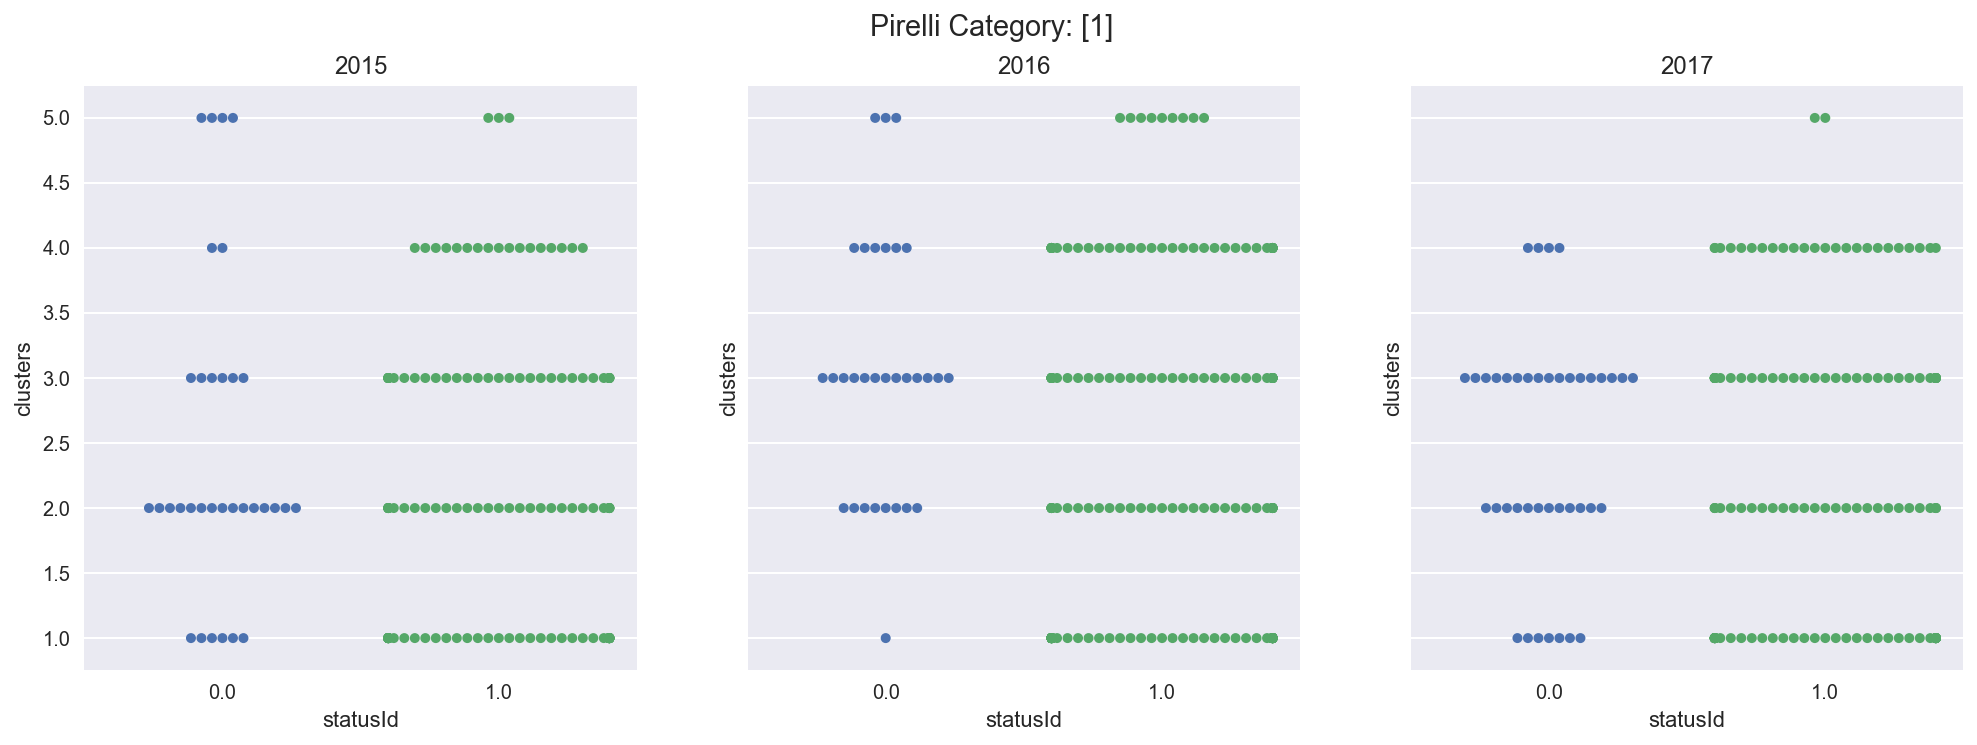

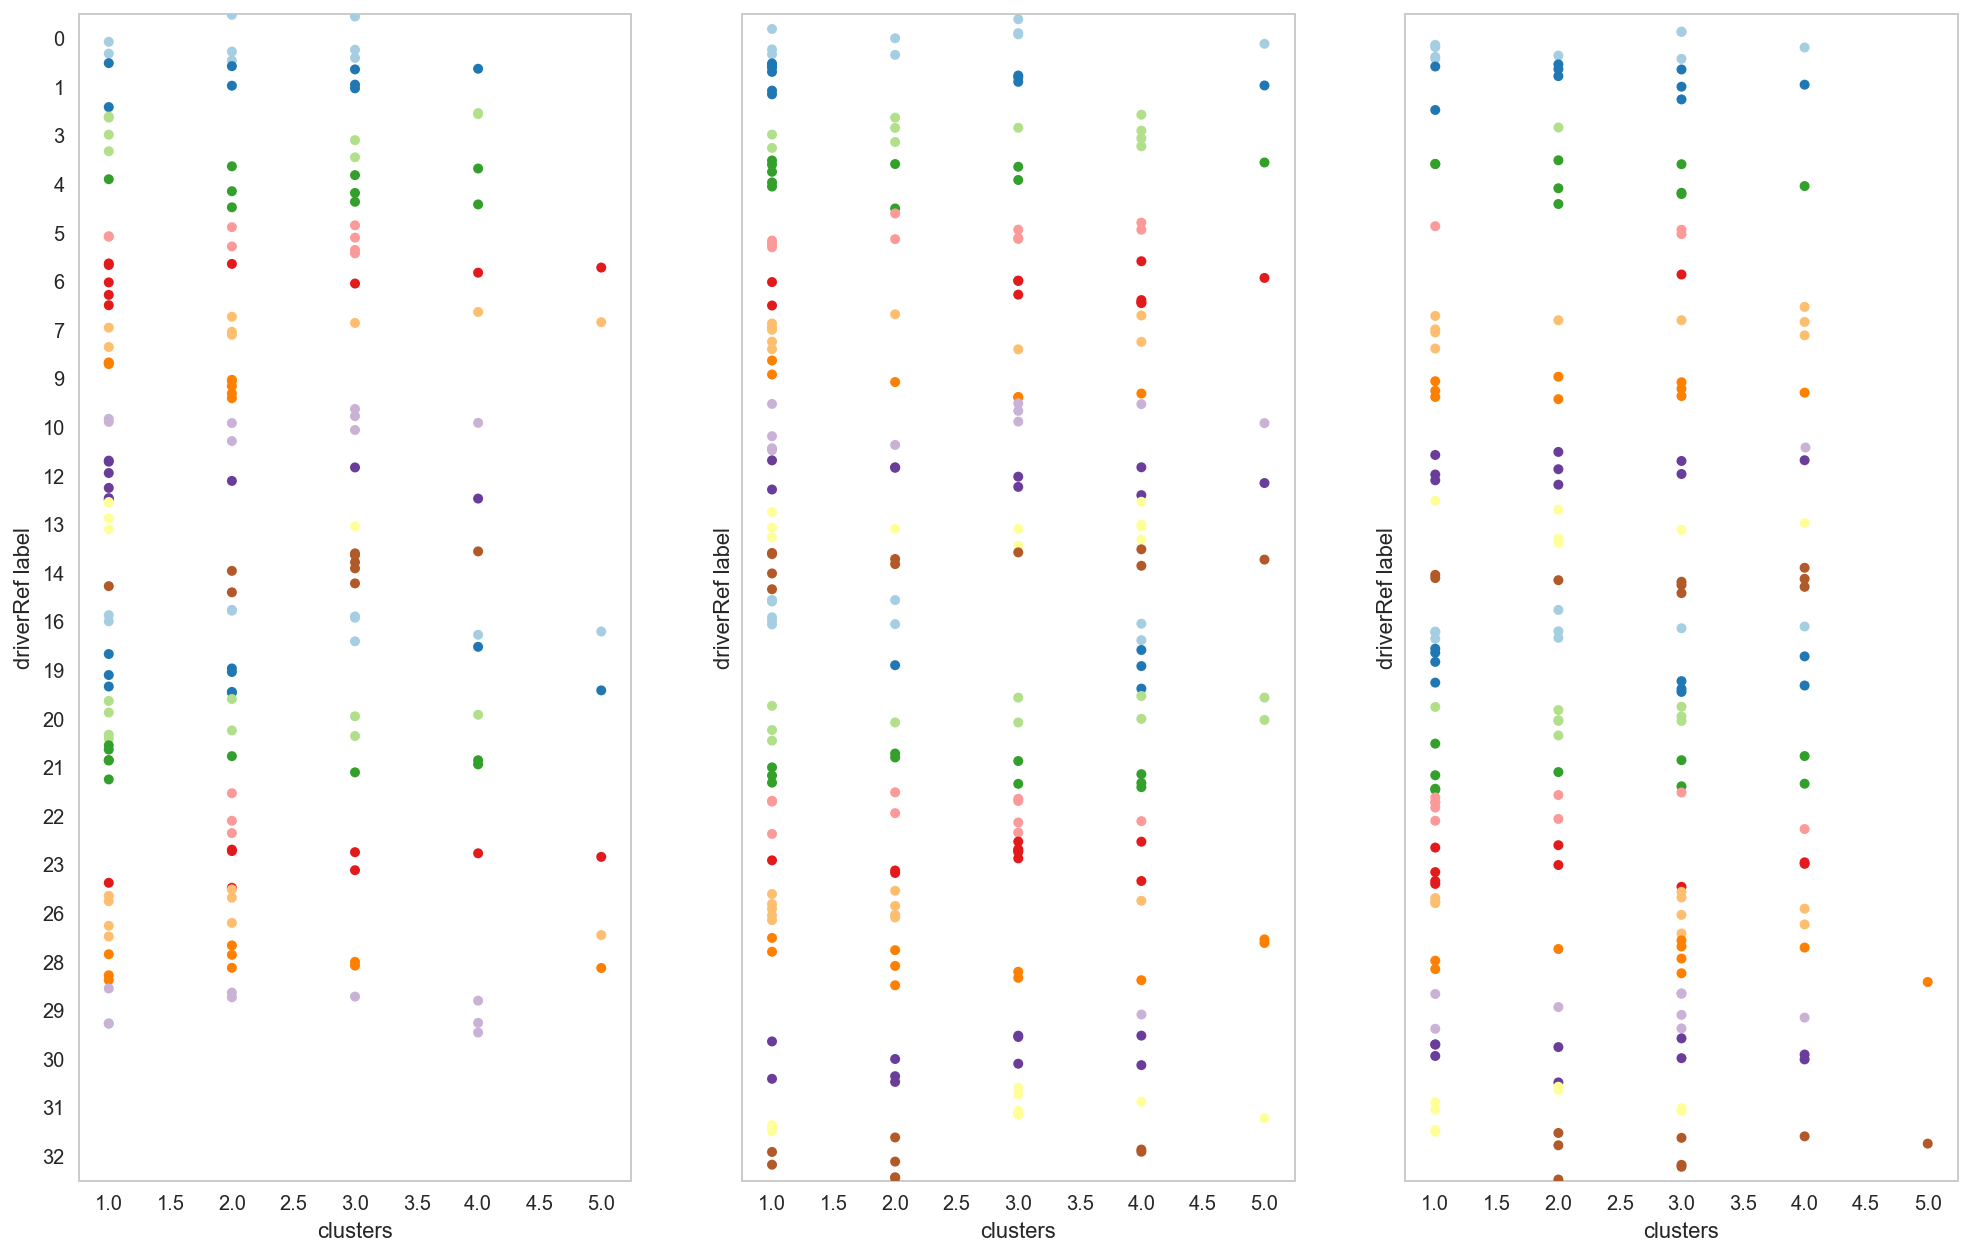

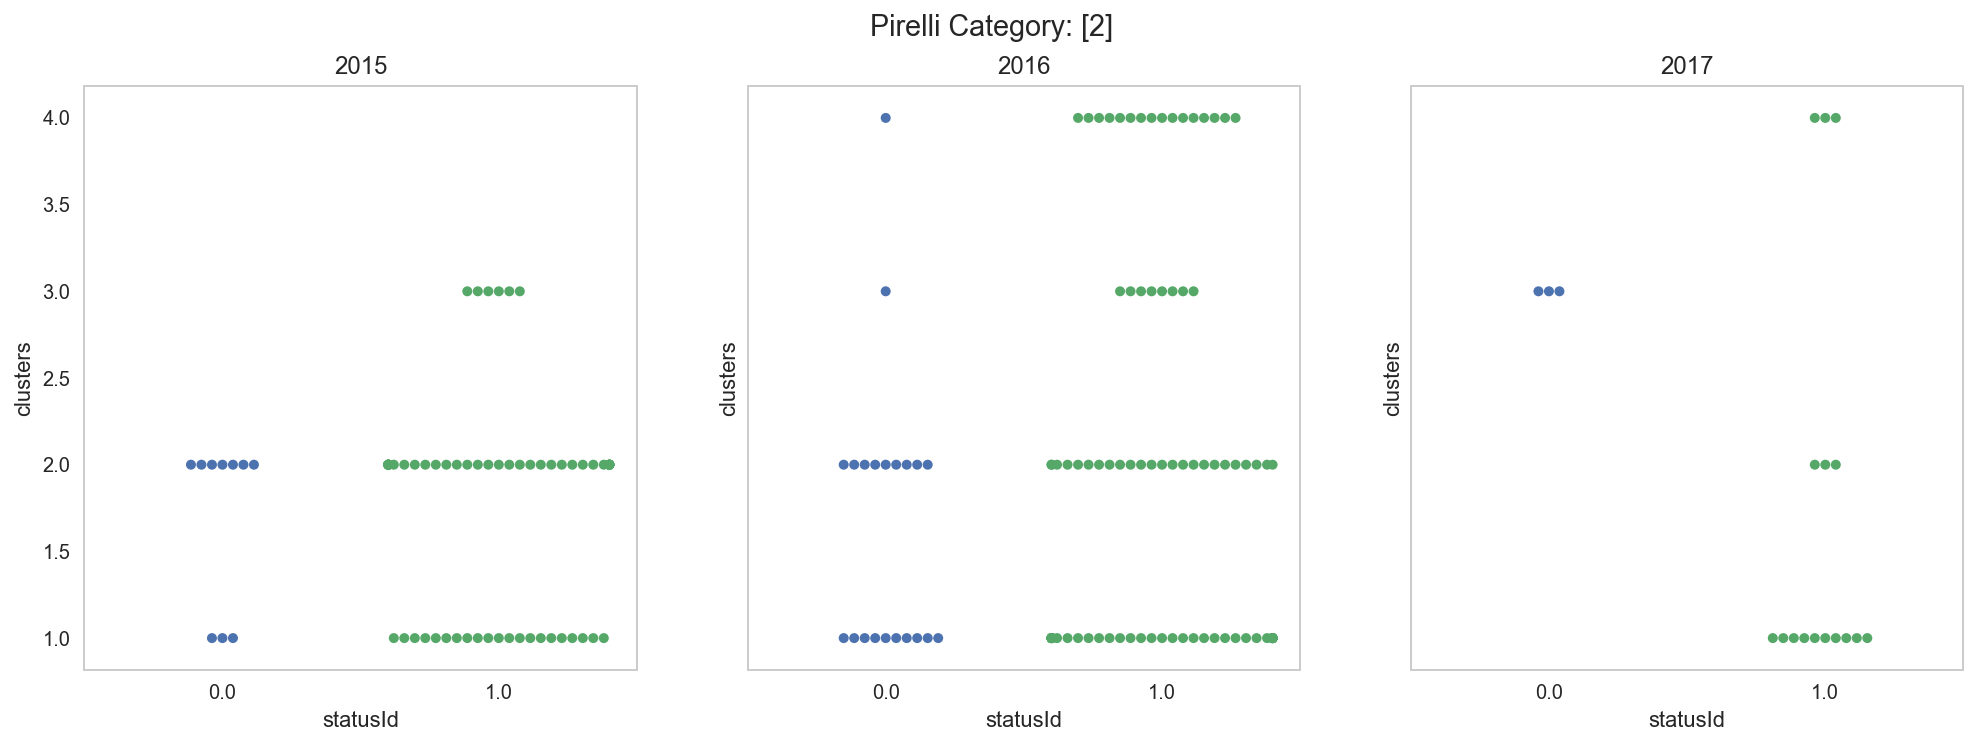

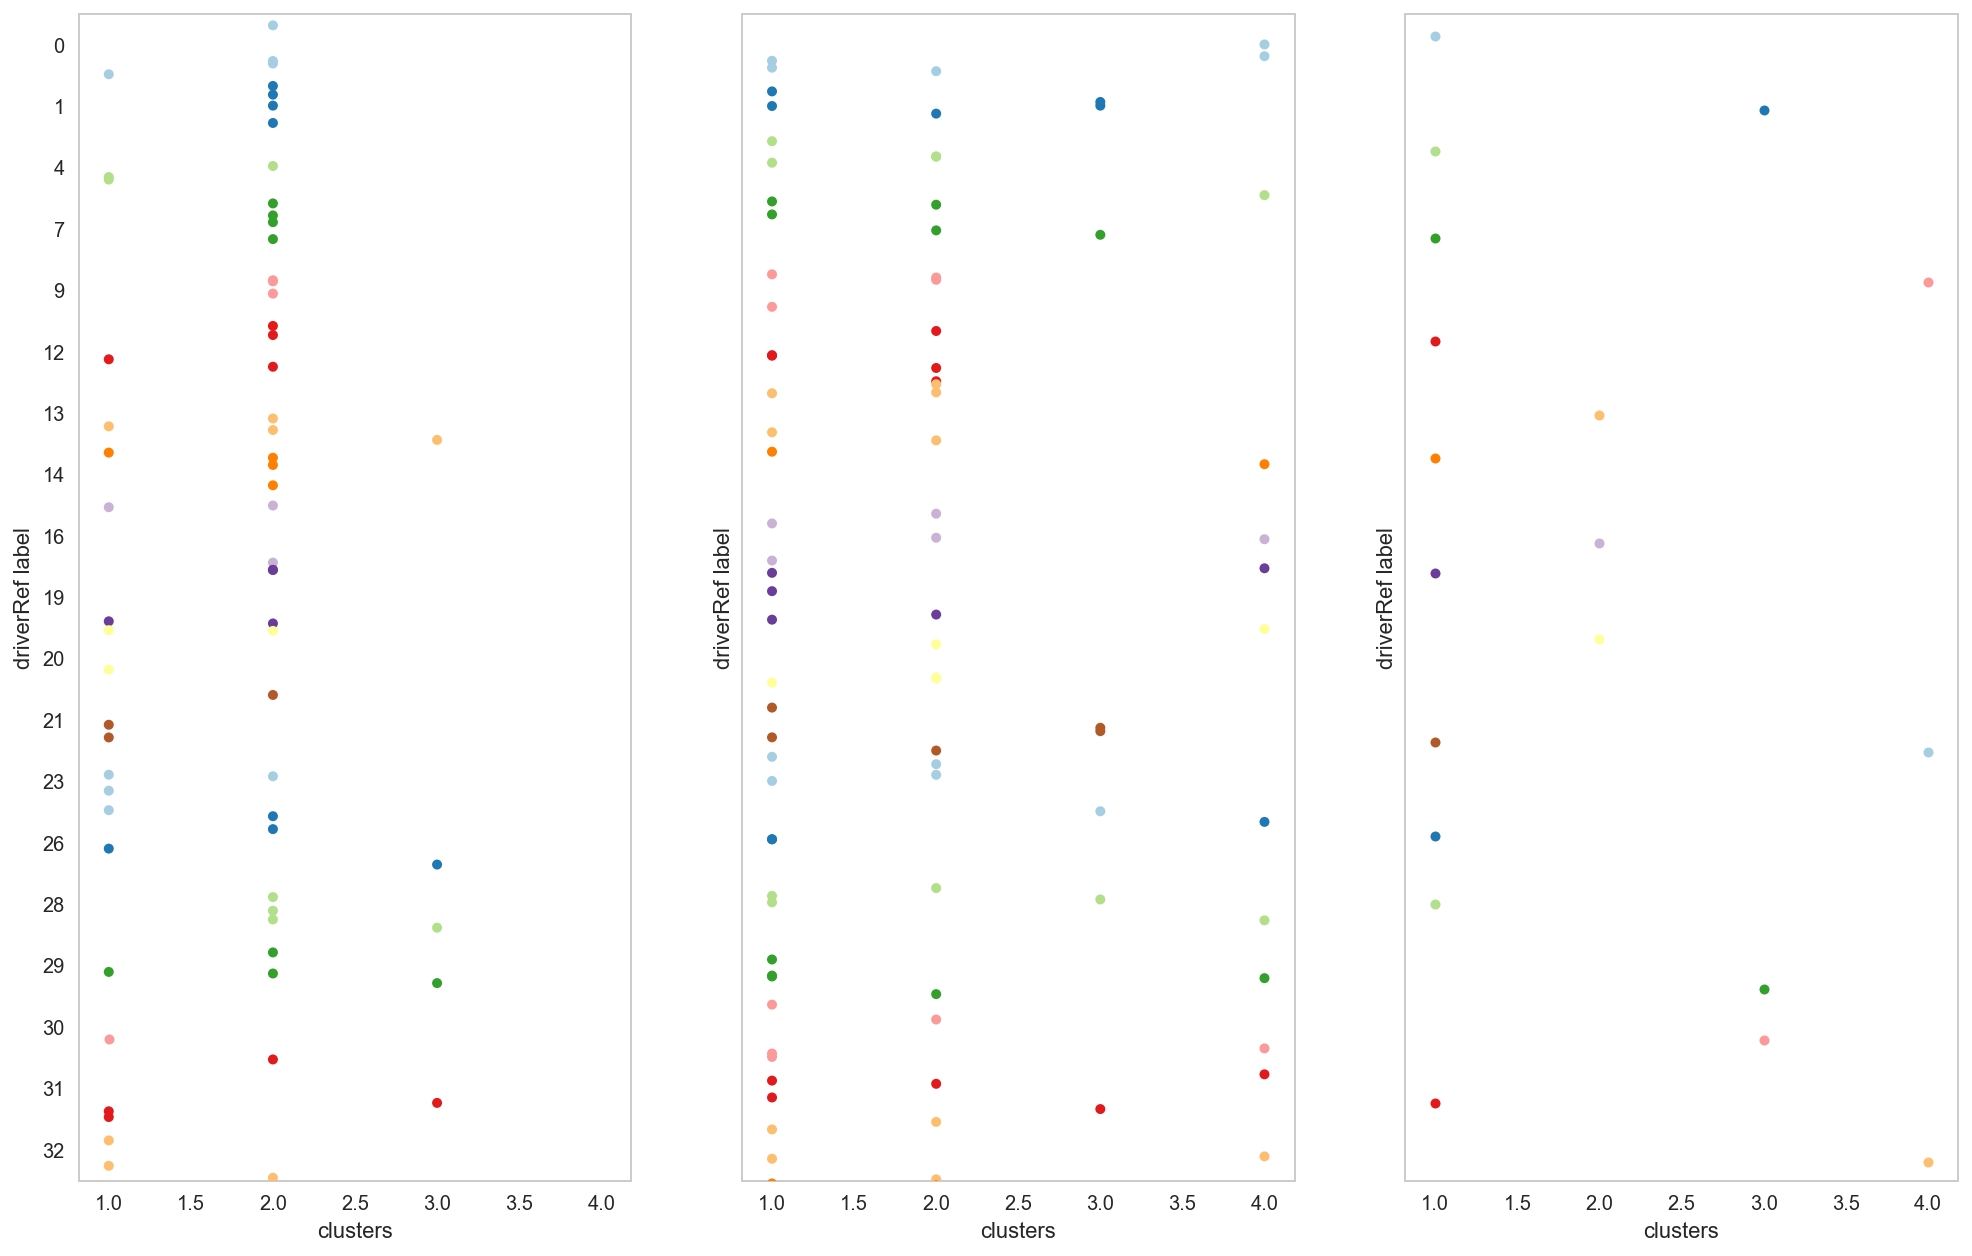

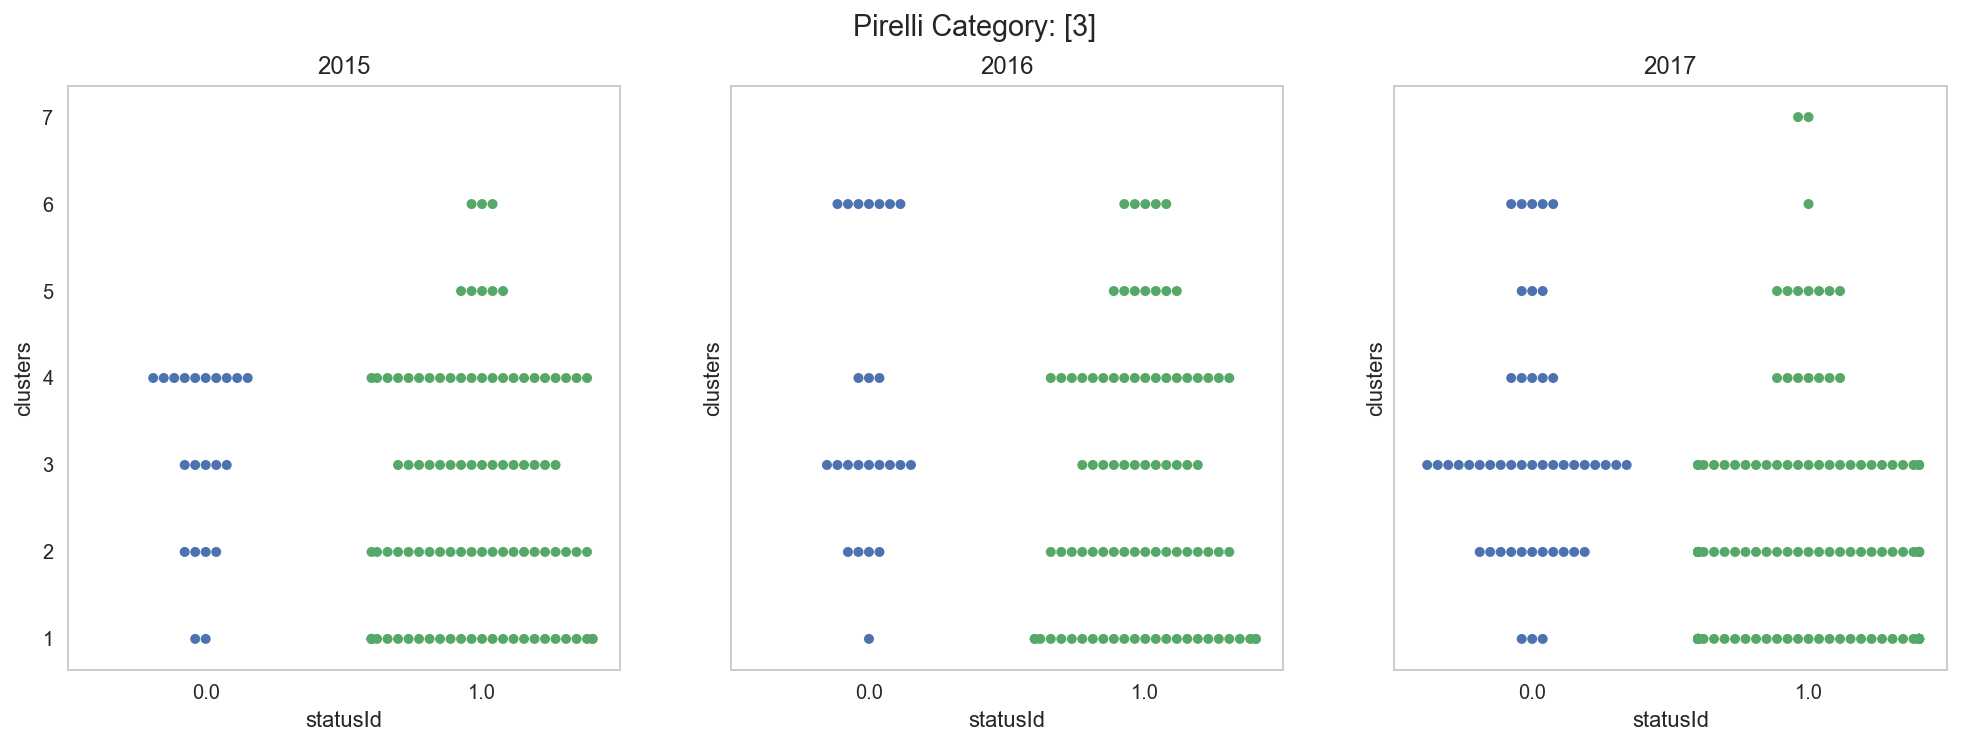

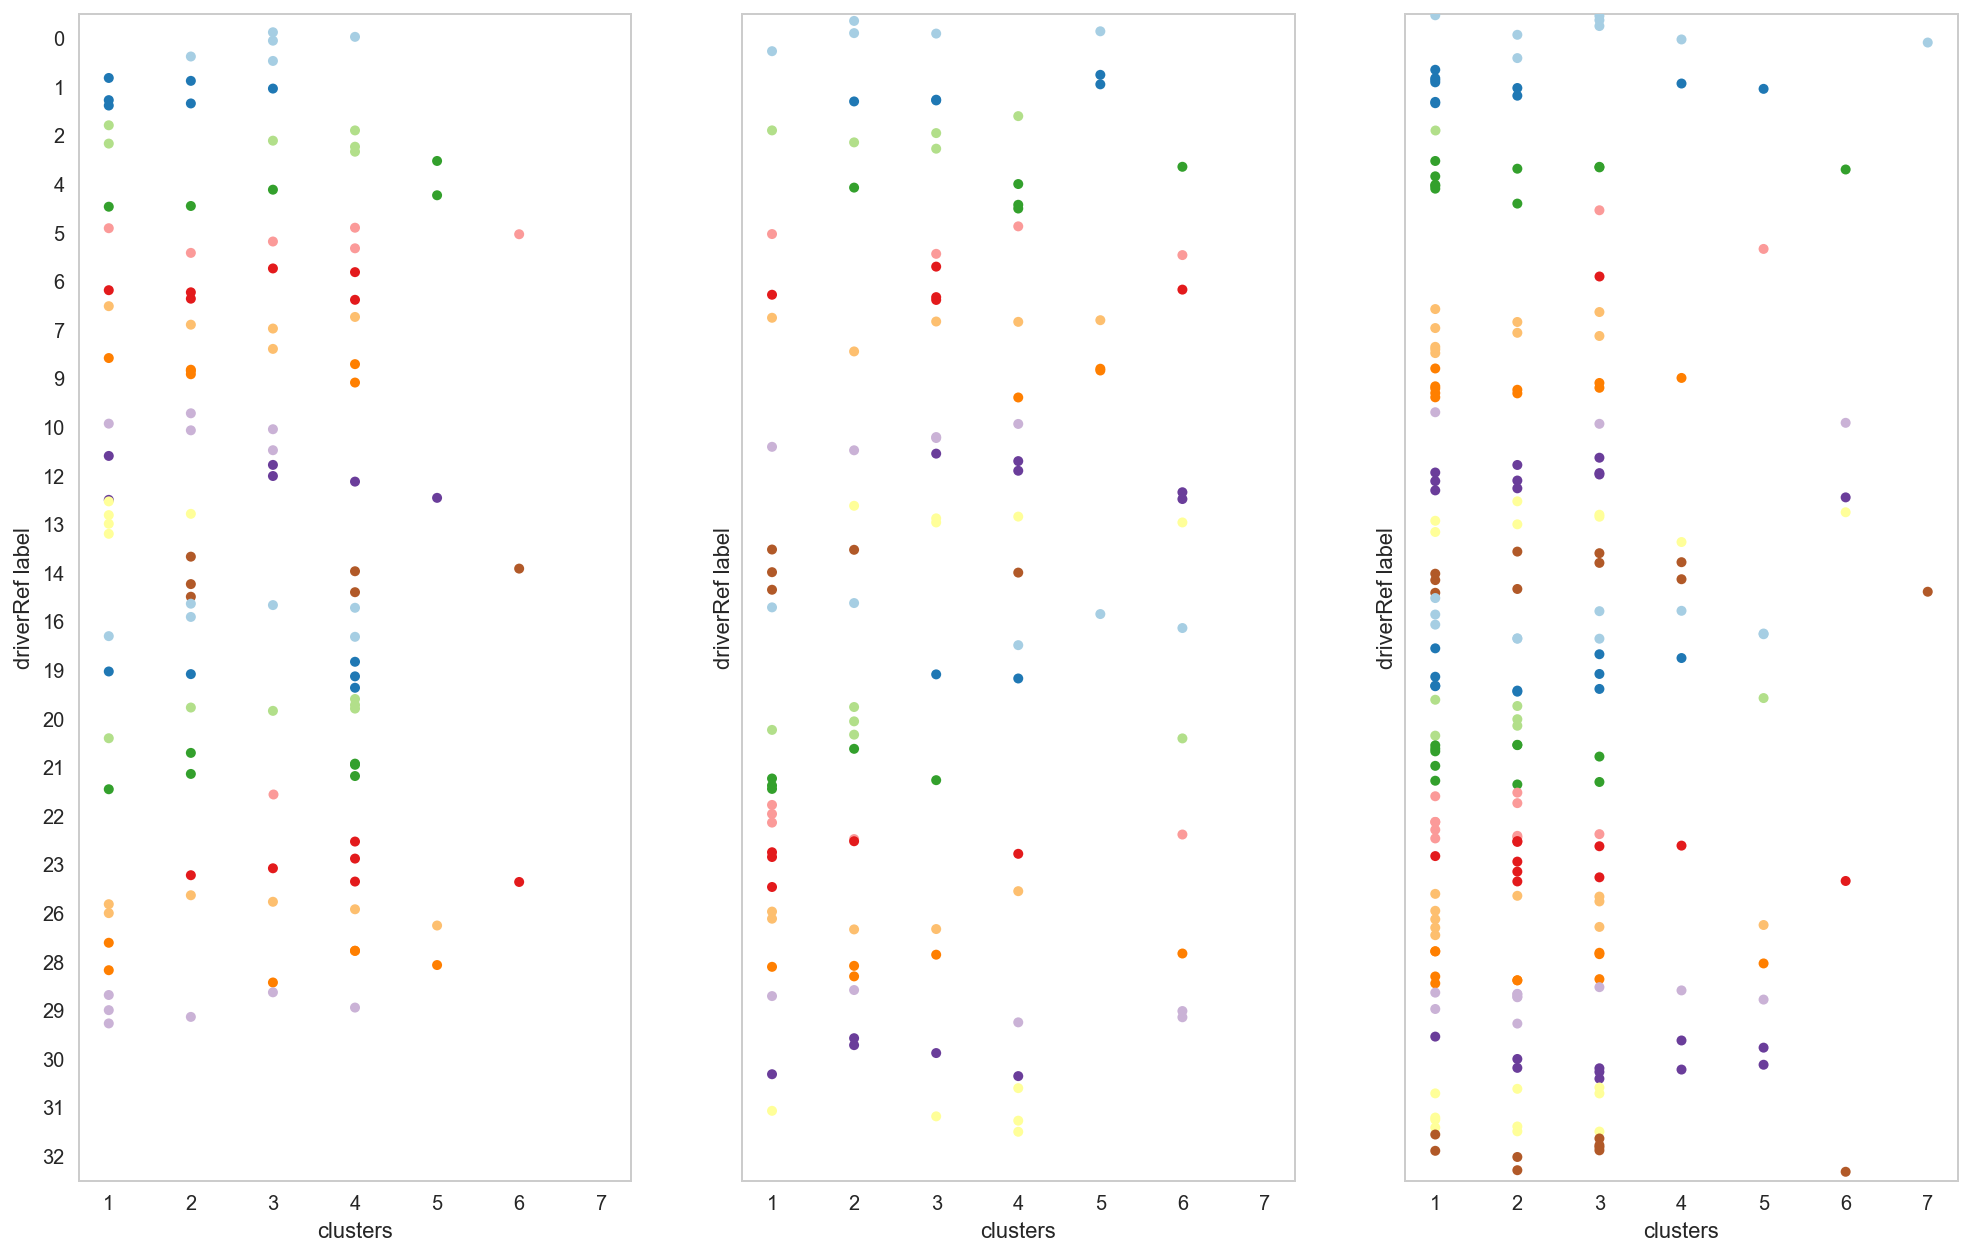

In [41]:
dfs = [df_clusters_cat1, df_clusters_cat2, df_clusters_cat3]
df_all = plot_loop(dfs, dataset, index_list, le, max_dist=50)

#### How to use cluster labels as features in classification problem?
- Note: Only information known pre-race can be included. Since we do not know the exact tyre strategy of each driver before a race, we are unable to perform clustering for a race before it starts.
- The next best option would be to use 2016's clustering for 2017. 

In [42]:
df_cat_statusId = df_all.drop(['pirelli category', 'max dist', 'driverRef label'], axis=1)

### Use 2016's clustering for 2017

In [43]:
df_cat_statusId1516 = df_cat_statusId[df_cat_statusId ['year'].isin([2015, 2016])]

In [44]:
df_cat_statusId17 = df_cat_statusId[df_cat_statusId ['year'].isin([2017])]

In [45]:
df_cat_statusId16 = df_cat_statusId[df_cat_statusId ['year'].isin([2016])]
df_cat_statusId16['year'] = 2017

use17 = pd.merge(df_cat_statusId16[['year', 'driverRef', 'name', 'clusters']].reset_index(drop=True), 
         df_cat_statusId17[['year', 'driverRef', 'name', 'statusId']].reset_index(drop=True), 
         on=index_list, how='left')

In [46]:
# Drop null values as these belong to drivers who did not participate in 2017
use17.isnull().sum()

year           0
driverRef      0
name           0
clusters       0
statusId     108
dtype: int64

In [49]:
use17 = use17.dropna(how='any', axis=0)
final = pd.concat([df_cat_statusId1516, use17])
final = final[['year', 'driverRef', 'name', 'clusters']]
final.to_pickle(os.path.join(directory,  'tyre_strategy_clusters1.pickle'))

In [51]:
final.head(20)

,year,driverRef,name,clusters
0,2015,button,Australian Grand Prix,1
1,2015,ericsson,Australian Grand Prix,2
2,2015,hamilton,Australian Grand Prix,1
3,2015,hulkenberg,Australian Grand Prix,1
4,2015,massa,Australian Grand Prix,1
5,2015,nasr,Australian Grand Prix,1
6,2015,perez,Australian Grand Prix,3
7,2015,raikkonen,Australian Grand Prix,2
8,2015,ricciardo,Australian Grand Prix,1
9,2015,rosberg,Australian Grand Prix,1
